In [ ]:
from google.colab import files

# Load kaggle.json
files.upload()
!ls -lha kaggle.json

KeyboardInterrupt: ignored

In [3]:
# Install Kaggle and Spark
!pip install -q kaggle pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download and unpack the dataset
!kaggle datasets download -f yelp_academic_dataset_review.json -d yelp-dataset/yelp-dataset
!unzip -n yelp_academic_dataset_review.json.zip

!kaggle datasets download -f yelp_academic_dataset_user.json -d yelp-dataset/yelp-dataset
!unzip -n yelp_academic_dataset_user.json.zip

100% 2.07G/2.07G [01:40<00:00, 17.4MB/s]
100% 2.07G/2.07G [01:40<00:00, 22.0MB/s]
Archive:  yelp_academic_dataset_review.json.zip
  inflating: yelp_academic_dataset_review.json  
100% 1.84G/1.84G [01:32<00:00, 28.5MB/s]
100% 1.84G/1.84G [01:32<00:00, 21.4MB/s]
Archive:  yelp_academic_dataset_user.json.zip
  inflating: yelp_academic_dataset_user.json  


In [4]:
import pyspark
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.mllib.linalg.distributed import *
from pyspark.mllib.linalg import *
from pyspark.accumulators import AccumulatorParam

from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from tabulate import tabulate
from datetime import datetime
from itertools import chain
from operator import add, and_
import numpy as np
import pandas as pd
from math import isclose
import re, os
import multiprocessing

# Specify the amount of entires to load or None to retain all entries
# This is used to test the implementation more quickly
entries = 100_000

In [ ]:
spark = pyspark.sql.SparkSession.builder \
    .master("local[*]") \
    .appName("yelp-ranking") \
    .getOrCreate()

sc = spark.sparkContext

In [ ]:
reviews = spark.read.json("yelp_academic_dataset_review.json")
if entries is not None: reviews = reviews.limit(entries)

reviews.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [ ]:
reviews = reviews.repartition("business_id")
reviews.rdd.getNumPartitions()

2

In [ ]:
# Build tuples in the shape (user, user) for users having reviewed the same business

# 1. Self-join the reviews on the business id
userpairs = reviews.alias("a").join(reviews.alias("b"), F.col("a.business_id") == F.col("b.business_id"))

# 2. Remove the pairs with the same user
userpairs = userpairs.filter(F.col("a.user_id") != F.col("b.user_id"))

# 3. Retain only the user ids
userpairs = userpairs.select(F.col("a.user_id"), F.col("b.user_id")).distinct()



In [ ]:
# Build a map from each user to an integer id

# 1. Extract all unique users
users = userpairs.rdd.map(lambda u: u[1]).distinct()

# 2. Add a unique identifier to each user
users = users.zipWithIndex()

# 3. Build { user -> id } map
usermap = sc.broadcast(users.collectAsMap())

# 4. Map both users to id
arcs = userpairs.rdd.map(lambda u: (usermap.value[u[0]], usermap.value[u[1]]))

print("Total arcs:", arcs.count())

Total arcs: 6874736


In [ ]:
# Compute the total number of users
n_users = usermap.value.get(max(usermap.value, key = usermap.value.get)) + 1

print("Total users:", n_users)

Total users: 77604


In [ ]:
# In this variable we'll store the results for every ranking
results = dict()

def add_result(rank_name, ranking):
    hvs = users.sortBy(lambda u: ranking[u[1]], False).take(5)
    results[rank_name] = {
        "ranking": np.copy(ranking),
        "heavyhitters": [(hv[0], ranking[hv[1]]) for hv in hvs],
    }

In [ ]:
# Map users to integer ids using the precomputed map

# All these joins are very spark-idiomatic, but terribly inefficient,
# a minimal perfect hashing would perform much better

# 1. Perform a join to map users to ids  u1 -> (u2, u1_id)
# arcs = userpairs.join(users)

# 2. Discard keys                        u2 -> u1_id
# arcs = arcs.map(lambda x: x[1])

# 3. Perform another join                u2 -> (u1_id, u2_id)
# arcs = arcs.join(users)

# 4. Discard keys                        u1_id -> u2_id
# arcs = arcs.map(lambda x: x[1])

# 5. Remove duplicates
# arcs = arcs.distinct()

# print("|{(u, v) | u and v reviewed the same business}| =", arcs.count())

In [ ]:
def adjacency_rows(user, neighbours):
    vector = SparseVector(n_users, neighbours, [1] * len(neighbours))
    return user, vector

rows = arcs.groupByKey().mapValues(sorted).map(lambda u: adjacency_rows(*u))
M = IndexedRowMatrix(rows, n_users, n_users)

In [ ]:
def normalize_row(row):
    row.vector = SparseVector(n_users, row.vector.indices, [1 / len(row.vector.indices)] * len(row.vector.indices))
    return row

normalized_rows = M.rows.map(normalize_row)
normalized_M = IndexedRowMatrix(normalized_rows, n_users, n_users)

In [ ]:
# Build the adjacency matrix as sparse matrix entries
# (no need to create the inverse entry because the join automatically created the extra tuples)
#M = CoordinateMatrix(arcs.map(lambda x: (*x, 1.)), n_users, n_users)

In [ ]:
# Normalize the matrix in L1 norm

# Normalize a row in L1 norm
# Being the rows sparse boolean vectors, we can
# simply divide by the number of non-zero elements
#def normalize(row):
#    vector = SparseVector(row.vector.size, row.vector.indices, row.vector.values / row.vector.values.size)
#    return IndexedRow(row.index, vector)

# We want to work on the rows
# note: we switch to BlockMatrix temporarily because otherwise we'd loose the rows with all zeroes
#normalized_rows = M.toIndexedRowMatrix().rows

# Build new rows with the underlying vectors normalized in L1 norm
#normalized_rows = normalized_rows.map(normalize)

# Build the normalized matrix
#normalized_M = IndexedRowMatrix(normalized_rows, n_users, n_users)

In [ ]:
# Sanity check: the rows of the matrix should add to one
# note: due to precision issues we are only checking that they are _close_ to 1

normalized_M.rows.map(lambda row: isclose(row.vector.values.sum(), 1.)).reduce(and_) \
    and "Don't Panic." or "Panic."

"Don't Panic."

In [ ]:
# Transpose to compute the negative rank (incoming nodes)
transposed_M = normalized_M.toCoordinateMatrix().transpose().toIndexedRowMatrix()

## Degree
We compute the degree for every user in the graph, defined as the number of users who reviewed the same business. Being the graph symmetric the degree coincides with both the indegree and outdegree.



In [ ]:
class VectorAccumulator(AccumulatorParam):
    def zero(self, other):
        return np.zeros(other.size)
    
    def addInPlace(self, a, b):
        a += b
        return a

In [ ]:
%%time
degree = sc.accumulator(np.zeros(n_users), VectorAccumulator())

def update_degrees(rows, accumulator):
    difference = np.zeros(n_users)
    for row in rows: difference[row.index] = row.vector.indices.size
    accumulator += difference

M.rows.foreachPartition(lambda rows: update_degrees(rows, degree))

CPU times: user 217 ms, sys: 20.4 ms, total: 237 ms
Wall time: 27.9 s


In [ ]:
add_result("Degree", degree.value)

## PageRank

$$ \begin{cases} v(0) = \mathbf{1} \frac{1}{n} \\ v(t + 1) = β M v(t) + (1 − β) \mathbf{1} \frac{1}{n} \end{cases} $$
where $n$ = `n_users` and $\beta = 0.85$.

In [ ]:
def pagerank(M, n, beta = 0.85, preference = None, tolerance = 10e-5, max_iterations = 100):
    rank = np.ones(n) / n
    preference = sc.broadcast((1 - beta) * \
        ((np.ones(n) / n) if preference is None else preference))

    def rankupdate(vec):
        def inner(row):
            return row.index, row.vector.dot(vec)
        return inner

    for it in range(1, max_iterations):
        # Compute the new page rank vector
        update = M.rows.map(rankupdate(rank)).sortByKey().collect()
        
        # Random surfing
        new_rank = beta * SparseVector(n, update).toArray() + preference.value
        
        # Compute change delta to identify a plateau
        dist = np.linalg.norm(new_rank - rank)
        
        # Update page rank approximation
        rank = new_rank

        print(f"{it}) dist: {dist}")

        if dist < tolerance:
            print("close enough...")
            break
    else:
        print("!!! reached maximum iterations !!!")

    return rank

In [ ]:
%%time
pr = pagerank(transposed_M, n_users)

1) dist: 0.002044068864446376
2) dist: 0.0004969894426284239
3) dist: 0.0002159445959465798
4) dist: 0.00015006366173088523
5) dist: 0.00010638001437030201
6) dist: 7.849815718623697e-05
close enough...
CPU times: user 4.73 s, sys: 814 ms, total: 5.54 s
Wall time: 10min 5s


In [ ]:
add_result("PageRank", pr)

## Topic-sensitive PageRank

Add a preference towards users who started *yelping* early. To do that we need information about the users, which we can gather from the `yelp_academic_dataset_user` dataset. Instead of a binary preference vector with the *preferred* users we'll define a real vector associating importance to each user.

In [ ]:
yelping = spark.read.json("yelp_academic_dataset_user.json")

In [ ]:
# Remove unknown users
filter_user = F.udf(lambda user_id: user_id in usermap.value, T.BooleanType())

yelping = yelping \
    .filter(filter_user(yelping.user_id))

In [ ]:
# Map users to their id
translate_user = F.udf(lambda col: usermap.value.get(col), T.IntegerType())

yelping = yelping \
    .withColumn("user_id", translate_user("user_id")) \
    .select("user_id", "useful", "funny", "cool")

In [ ]:
# Compute the 80-th percentile for the three review columns
quantiles = yelping.approxQuantile(["useful", "funny", "cool"], [0.8], 0.1)
quantiles 

[[66.0], [16.0], [20.0]]

In [ ]:
class BoolVectorAccumulator(AccumulatorParam):
    def zero(self, other):
        return np.full(other.size, False)
    
    def addInPlace(self, a, b):
        a = a | b
        return a

In [ ]:
%%time

# Build binary vectors with the users above the 80-th percentile for each category

useful = sc.accumulator(np.full(n_users, False), BoolVectorAccumulator())
funny = sc.accumulator(np.full(n_users, False), BoolVectorAccumulator())
cool = sc.accumulator(np.full(n_users, False), BoolVectorAccumulator())

def update_categories(partition, useful, funny, cool, quantiles):
    useful_d = np.full(n_users, False)
    funny_d = np.full(n_users, False)
    cool_d = np.full(n_users, False)

    for row in partition:
        useful_d[row.user_id] = row.useful >= quantiles[0][0]
        funny_d[row.user_id] = row.funny >= quantiles[1][0]
        cool_d[row.user_id] = row.cool >= quantiles[2][0]

    useful += useful_d
    funny += funny_d
    cool += cool_d

yelping.foreachPartition(lambda p: update_categories(p, useful, funny, cool, quantiles))
useful, funny, cool

CPU times: user 347 ms, sys: 45.5 ms, total: 393 ms
Wall time: 41.8 s


(Accumulator<id=1, value=[False False False ... False False  True]>,
 Accumulator<id=2, value=[False False False ... False False  True]>,
 Accumulator<id=3, value=[False False False ... False False  True]>)

In [ ]:
# Normalize the preference vectors

useful = useful.value / useful.value.sum()
funny = funny.value / funny.value.sum()
cool = cool.value / cool.value.sum()

In [ ]:
%%time
tspr = pagerank(transposed_M, n_users, preference = np.copy(useful))

1) dist: 0.0025015901398436824
2) dist: 0.0006205311354268815
3) dist: 0.0003398253632691729
4) dist: 0.0002516344318073528
5) dist: 0.00019208742377962364
6) dist: 0.00015011033900161626
7) dist: 0.0001194643672799424
8) dist: 9.584565683788466e-05
close enough...
CPU times: user 5.69 s, sys: 1.15 s, total: 6.84 s
Wall time: 12min 16s


In [ ]:
add_result("TsPR (useful)", tspr)

In [ ]:
%%time
tspr = pagerank(transposed_M, n_users, preference = np.copy(funny))

1) dist: 0.002501212454905288
2) dist: 0.0006229021712459834
3) dist: 0.0003448222903472278
4) dist: 0.00025652609950849517
5) dist: 0.00019639665449947948
6) dist: 0.00015403736065393994
7) dist: 0.00012276796650418528
8) dist: 9.877950342302763e-05
close enough...
CPU times: user 5.39 s, sys: 1.2 s, total: 6.59 s
Wall time: 12min 1s


In [ ]:
add_result("TsPR (funny)", tspr)

In [ ]:
%%time
tspr = pagerank(transposed_M, n_users, preference = np.copy(cool))

1) dist: 0.002503457910434264
2) dist: 0.0006271947510122003
3) dist: 0.0003449721311987024
4) dist: 0.00025602581401911844
5) dist: 0.00019532270613642787
6) dist: 0.00015299840059865237
7) dist: 0.0001215712248555906
8) dist: 9.779859852742916e-05
close enough...
CPU times: user 5.38 s, sys: 1.02 s, total: 6.4 s
Wall time: 11min 56s


In [ ]:
add_result("TsPR (cool)", tspr)

## HITS
We are computing the ranking as hubs and authorities for each user.

note: being the relationship symmetric the two rankings coincide.

In [ ]:
def hits(L, L_t, n, max_iterations = 100, tolerance = 10e-5):
    auth = np.ones(n)
    hub = np.ones(n)

    def hub_step(auth):
        updated = L.rows.map(lambda row: (row.index, row.vector.dot(auth))).collect()
        return SparseVector(n, updated).toArray()

    def auth_step(hub):
        updated = L_t.rows.map(lambda row: (row.index, row.vector.dot(hub))).collect()
        return SparseVector(n, updated).toArray()

    for it in range(1, max_iterations):
        new_hub = hub_step(auth)
        new_hub /= np.linalg.norm(new_hub)

        dist_hub = np.linalg.norm(new_hub - hub)
        hub = new_hub

        new_auth = auth_step(hub)
        new_auth /= np.linalg.norm(new_auth)

        dist_auth = np.linalg.norm(new_auth - auth)
        auth = new_auth

        print(f"{it}) dist: [hub] {dist_hub} [auth] {dist_auth}")

        if max(dist_hub, dist_auth) < tolerance:
            print("close enough...")
            break
    else:
        print("!!! reached maximum iterations !!!")

    return hub, auth

In [ ]:
%%time
hub, auth = hits(M, M.toCoordinateMatrix().transpose().toIndexedRowMatrix(), n_users)

1) dist: [hub] 278.0557072116904 [auth] 278.31839707958187
2) dist: [hub] 0.7194933299402343 [auth] 0.3109962739291187
3) dist: [hub] 0.1262405672385407 [auth] 0.053040787682742306
4) dist: [hub] 0.023031222186044035 [auth] 0.010230341210282237
5) dist: [hub] 0.004614629906340047 [auth] 0.0021038230411458254
6) dist: [hub] 0.000966482814388003 [auth] 0.00044651221897403886
7) dist: [hub] 0.00020718189855930687 [auth] 9.646141974418976e-05
8) dist: [hub] 4.503584490789756e-05 [auth] 2.107467819518528e-05
close enough...
CPU times: user 6.46 s, sys: 1.62 s, total: 8.08 s
Wall time: 8min 9s


In [ ]:
add_result("HITS (hub)", hub)
add_result("HITS (auth)", auth)

## Results

In [15]:
!mkdir plots

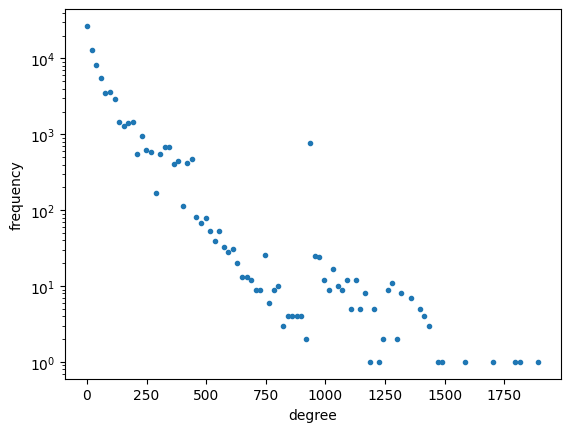

In [ ]:
pp = PdfPages('plots/degree.pdf')

ax = plt.subplot()
counts, bins = np.histogram(results["Degree"]["ranking"], bins=100)
ax.scatter(bins[:-1], counts, marker=".")
ax.set_yscale("log")
plt.xlabel("degree")
plt.ylabel("frequency")

pp.savefig()
pp.close()
plt.show()

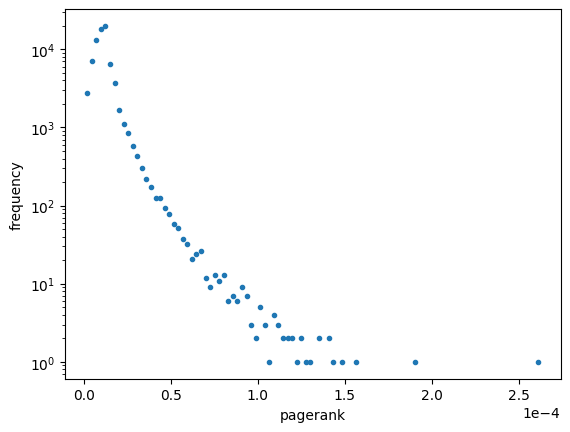

In [ ]:
pp = PdfPages('plots/pagerank.pdf')

ax = plt.subplot()
counts, bins = np.histogram(results["PageRank"]["ranking"], bins=100)
ax.scatter(bins[:-1], counts, marker=".")
ax.set_yscale("log")
ax.ticklabel_format(axis="x", scilimits=(0,0))
plt.xlabel("pagerank")
plt.ylabel("frequency")

pp.savefig()
pp.close()
plt.show()

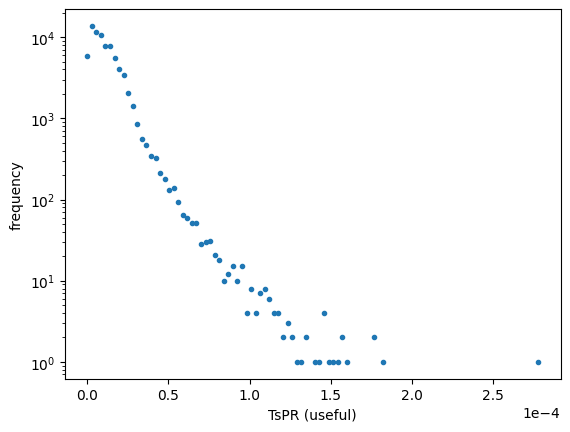

In [ ]:
pp = PdfPages('plots/tspr-useful.pdf')

ax = plt.subplot()
counts, bins = np.histogram(results["TsPR (useful)"]["ranking"], bins=100)
ax.scatter(bins[:-1], counts, marker=".")
ax.set_yscale("log")
ax.ticklabel_format(axis="x", scilimits=(0,0))
plt.xlabel("TsPR (useful)")
plt.ylabel("frequency")

pp.savefig()
pp.close()
plt.show()

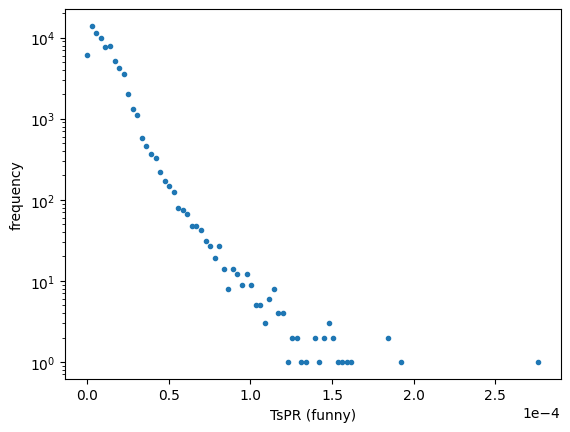

In [ ]:
pp = PdfPages('plots/tspr-funny.pdf')

ax = plt.subplot()
counts, bins = np.histogram(results["TsPR (funny)"]["ranking"], bins=100)
ax.scatter(bins[:-1], counts, marker=".")
ax.set_yscale("log")
ax.ticklabel_format(axis="x", scilimits=(0,0))
plt.xlabel("TsPR (funny)")
plt.ylabel("frequency")

pp.savefig()
pp.close()
plt.show()

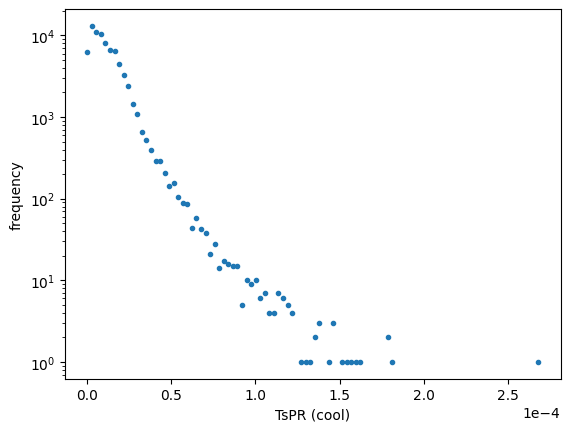

In [ ]:
pp = PdfPages('plots/tspr-cool.pdf')

ax = plt.subplot()
counts, bins = np.histogram(results["TsPR (cool)"]["ranking"], bins=100)
ax.scatter(bins[:-1], counts, marker=".")
ax.set_yscale("log")
ax.ticklabel_format(axis="x", scilimits=(0,0))
plt.xlabel("TsPR (cool)")
plt.ylabel("frequency")

pp.savefig()
pp.close()
plt.show()

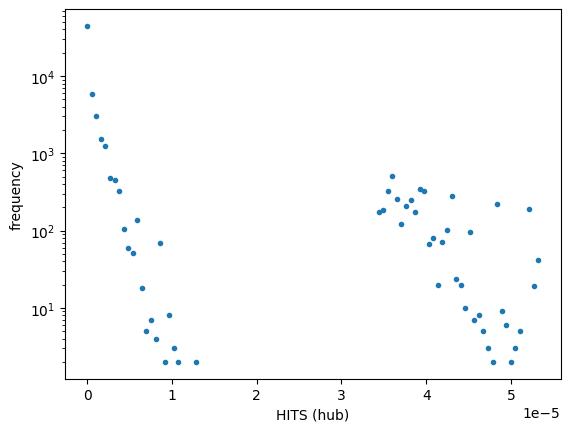

In [ ]:
pp = PdfPages('plots/hits-hub.pdf')

ax = plt.subplot()
filter = (results["HITS (hub)"]["ranking"] > np.percentile(results["HITS (hub)"]["ranking"], 10)) & \
         (results["HITS (hub)"]["ranking"] < np.percentile(results["HITS (hub)"]["ranking"], 90))
counts, bins = np.histogram(results["HITS (hub)"]["ranking"][filter], bins=100)
ax.scatter(bins[:-1], counts, marker=".")
ax.set_yscale("log")
ax.ticklabel_format(axis="x", scilimits=(0,0))
plt.xlabel("HITS (hub)")
plt.ylabel("frequency")

pp.savefig()
pp.close()
plt.show()

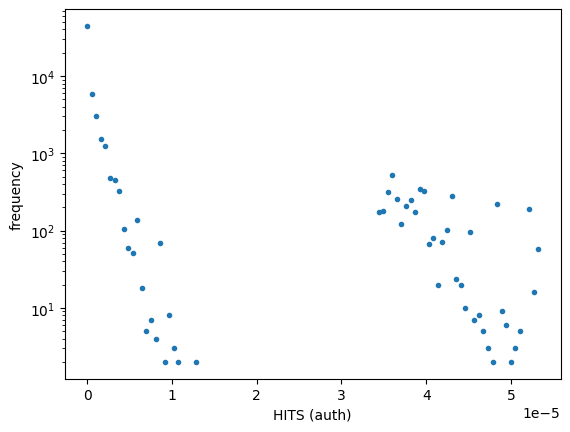

In [ ]:
pp = PdfPages('plots/hits-auth.pdf')

ax = plt.subplot()
filter = (results["HITS (auth)"]["ranking"] > np.percentile(results["HITS (auth)"]["ranking"], 10)) & \
         (results["HITS (auth)"]["ranking"] < np.percentile(results["HITS (auth)"]["ranking"], 90))
counts, bins = np.histogram(results["HITS (auth)"]["ranking"][filter], bins=100)
ax.scatter(bins[:-1], counts, marker=".")
ax.set_yscale("log")
ax.ticklabel_format(axis="x", scilimits=(0,0))
plt.xlabel("HITS (auth)")
plt.ylabel("frequency")

pp.savefig()
pp.close()
plt.show()

In [ ]:
!zip plots.zip plots/*

updating: plots/degree.pdf (deflated 30%)
updating: plots/hits-auth.pdf (deflated 32%)
updating: plots/hits-hub.pdf (deflated 32%)
updating: plots/pagerank.pdf (deflated 31%)
updating: plots/tspr-cool.pdf (deflated 32%)
updating: plots/tspr-funny.pdf (deflated 32%)
updating: plots/tspr-useful.pdf (deflated 33%)


In [ ]:
for rank, data in results.items():
    print(f"{rank}:")
    for index, hv in enumerate(data["heavyhitters"]):
        print(f"{index+1:02d}. {hv[0]} [rank {hv[1]:0.5f}]")
    print()

Degree:
01. CfX4sTIFFNaRchNswqhVfg [rank 1911.00000]
02. tNq35k92WAkSLSqeof03hg [rank 1824.00000]
03. hmVE7u0Nt45j5sZCH9j_YQ [rank 1801.00000]
04. LO_YM_4kdAkRgf2wz1Kacw [rank 1707.00000]
05. xqS2PjKu16g2cFDBNgJ8Ng [rank 1591.00000]

PageRank:
01. _BcWyKQL16ndpBdggh2kNA [rank 0.00026]
02. Xw7ZjaGfr0WNVt6s_5KZfA [rank 0.00019]
03. 1HM81n6n4iPIFU5d2Lokhw [rank 0.00016]
04. mzL0zHFGyd9866OUljq49g [rank 0.00015]
05. ouODopBKF3AqfCkuQEnrDg [rank 0.00014]

HITS (hub):
01. LO_YM_4kdAkRgf2wz1Kacw [rank 0.03308]
02. hmVE7u0Nt45j5sZCH9j_YQ [rank 0.03299]
03. tNq35k92WAkSLSqeof03hg [rank 0.03295]
04. CfX4sTIFFNaRchNswqhVfg [rank 0.03292]
05. bdIueXy-Sc0DfqzXbm9AEg [rank 0.03290]

HITS (auth):
01. LO_YM_4kdAkRgf2wz1Kacw [rank 0.03308]
02. hmVE7u0Nt45j5sZCH9j_YQ [rank 0.03299]
03. tNq35k92WAkSLSqeof03hg [rank 0.03295]
04. CfX4sTIFFNaRchNswqhVfg [rank 0.03292]
05. bdIueXy-Sc0DfqzXbm9AEg [rank 0.03290]

TsPR (funny):
01. _BcWyKQL16ndpBdggh2kNA [rank 0.00028]
02. 1HM81n6n4iPIFU5d2Lokhw [rank 0.00019]


In [ ]:
hv = [["\\texttt{" + hv[0][:5].replace('_', '\_') + "}" for hv in data["heavyhitters"]] for rank, data in results.items()]
hv.insert(0, list(range(1, len(results["PageRank"]["heavyhitters"]) + 1)))
hv = list(map(list, zip(*hv)))
print(tabulate(hv, results.keys(), tablefmt="latex_raw", floatfmt=".4f"))

\begin{tabular}{rlllllll}
\hline
    & Degree          & PageRank        & HITS (hub)      & HITS (auth)     & TsPR (funny)    & TsPR (cool)     & TsPR (useful)   \\
\hline
  1 & \texttt{CfX4s}  & \texttt{\_BcWy} & \texttt{LO\_YM} & \texttt{LO\_YM} & \texttt{\_BcWy} & \texttt{\_BcWy} & \texttt{\_BcWy} \\
  2 & \texttt{tNq35}  & \texttt{Xw7Zj}  & \texttt{hmVE7}  & \texttt{hmVE7}  & \texttt{1HM81}  & \texttt{mzL0z}  & \texttt{mzL0z}  \\
  3 & \texttt{hmVE7}  & \texttt{1HM81}  & \texttt{tNq35}  & \texttt{tNq35}  & \texttt{mzL0z}  & \texttt{Xw7Zj}  & \texttt{1HM81}  \\
  4 & \texttt{LO\_YM} & \texttt{mzL0z}  & \texttt{CfX4s}  & \texttt{CfX4s}  & \texttt{Xw7Zj}  & \texttt{1HM81}  & \texttt{Xw7Zj}  \\
  5 & \texttt{xqS2P}  & \texttt{ouODo}  & \texttt{bdIue}  & \texttt{bdIue}  & \texttt{Hxx8F}  & \texttt{2iS1v}  & \texttt{Hxx8F}  \\
\hline
\end{tabular}


In [ ]:
ranks = np.stack([a["order"] for a in results.values()])

sim = [[None for _ in results.keys()] for _ in results.keys()]
for i, d1 in enumerate(results.values()):
    for j, d2 in enumerate(results.values()):
        sim[i][j] = f"${spearmanr(d1['ranking'], d2['ranking']).statistic:.3f}$"

print(tabulate(([rank] + list(row) for rank, row in zip(results.keys(), sim)), results.keys(), tablefmt="latex_raw"))

\begin{tabular}{llllllll}
\hline
               & Degree   & PageRank   & HITS (hub)   & HITS (auth)   & TsPR (funny)   & TsPR (cool)   & TsPR (useful)   \\
\hline
 Degree        & $1.000$  & $0.720$    & $0.804$      & $0.804$       & $0.714$        & $0.723$       & $0.716$         \\
 PageRank      & $0.720$  & $1.000$    & $0.380$      & $0.380$       & $0.703$        & $0.711$       & $0.715$         \\
 HITS (hub)    & $0.804$  & $0.380$    & $1.000$      & $1.000$       & $0.517$        & $0.509$       & $0.509$         \\
 HITS (auth)   & $0.804$  & $0.380$    & $1.000$      & $1.000$       & $0.516$        & $0.509$       & $0.508$         \\
 TsPR (funny)  & $0.714$  & $0.703$    & $0.517$      & $0.516$       & $1.000$        & $0.921$       & $0.938$         \\
 TsPR (cool)   & $0.723$  & $0.711$    & $0.509$      & $0.509$       & $0.921$        & $1.000$       & $0.943$         \\
 TsPR (useful) & $0.716$  & $0.715$    & $0.509$      & $0.508$       & $0.938$        & $0.

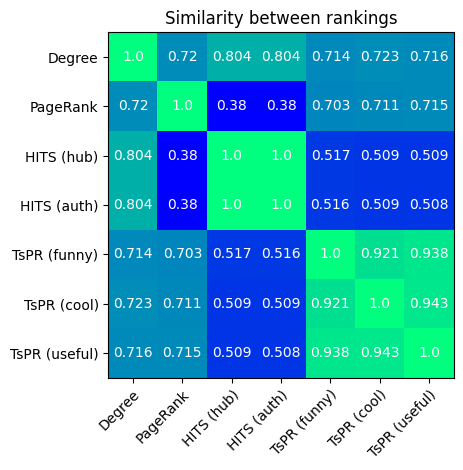

In [16]:
keys = ["Degree", "PageRank", "HITS (hub)", "HITS (auth)", "TsPR (funny)", "TsPR (cool)", "TsPR (useful)"]
sim = np.array([ \
    [1.000, 0.720, 0.804, 0.804, 0.714, 0.723, 0.716], \
    [0.720, 1.000, 0.380, 0.380, 0.703, 0.711, 0.715], \
    [0.804, 0.380, 1.000, 1.000, 0.517, 0.509, 0.509], \
    [0.804, 0.380, 1.000, 1.000, 0.516, 0.509, 0.508], \
    [0.714, 0.703, 0.517, 0.516, 1.000, 0.921, 0.938], \
    [0.723, 0.711, 0.509, 0.509, 0.921, 1.000, 0.943], \
    [0.716, 0.715, 0.509, 0.508, 0.938, 0.943, 1.000]])

pp = PdfPages('plots/sim.pdf')

fig, ax = plt.subplots()
im = ax.imshow(sim, cmap="winter")

ax.set_xticks(np.arange(len(keys)), labels=keys)
ax.set_yticks(np.arange(len(keys)), labels=keys)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

for i in range(len(keys)):
    for j in range(len(keys)):
        text = ax.text(j, i, sim[i, j], ha="center", va="center", color="w")

ax.set_title("Similarity between rankings")
fig.tight_layout()

pp.savefig()
pp.close()
plt.show()